In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import numpy as np
df = pd.read_csv("../../mnt/c/Users/sriha/Downloads/loan.csv",low_memory=False)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df.dropna(thresh = df.shape[0]*0.2,axis=1,inplace=True)

In [4]:
df.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                          'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                          'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [5]:
df["loan_status"].value_counts(normalize=True)


loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [6]:
df["good/bad"] = np.where(df.loc[:,"loan_status"].isin(['Charged Off', 'Default',
                                                                       'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']),0,1)

In [7]:
df.drop(columns=['loan_status'],inplace=True)

In [8]:
X = df.drop('good/bad',axis=1)
y = df['good/bad']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42, stratify = y)

In [10]:
X_train, X_test = X_train.copy(), X_test.copy()

In [11]:
X_train["emp_length"] = X_train["emp_length"].str.replace('+', '')

In [12]:
X_train["emp_length"] = X_train["emp_length"].str.replace('years',"")

In [13]:
X_train["emp_length"] = X_train["emp_length"].str.replace(' year',"")

In [14]:
X_train["emp_length"] =X_train["emp_length"].str.replace('< 1',str(0))

In [15]:
X_train["emp_length"] = pd.to_numeric(X_train["emp_length"])

In [16]:
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2020-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / 
							np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(
		lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)
    
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

In [17]:
def loan_term_converter(df_a, column):
    df_a[column] = pd.to_numeric(df_a[column].str.replace('months', ''))


In [18]:
X_train["term"] = X_train["term"].str.replace('months', '')

In [19]:
len(X_train.columns)

42

In [20]:
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()
chi2_check = {}

In [21]:
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

In [22]:
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)

In [23]:
chi2_result

,Feature,p-value
0,term,0.000000
1,grade,0.000000
2,home_ownership,0.000000
3,verification_status,0.000000
4,purpose,0.000000
5,addr_state,0.000000
6,initial_list_status,0.000000
7,pymnt_plan,0.000923
8,application_type,1.000000


In [24]:
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)

ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values,
					'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()

/home/iampoppyxx/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/iampoppyxx/.local/lib/python3.9/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


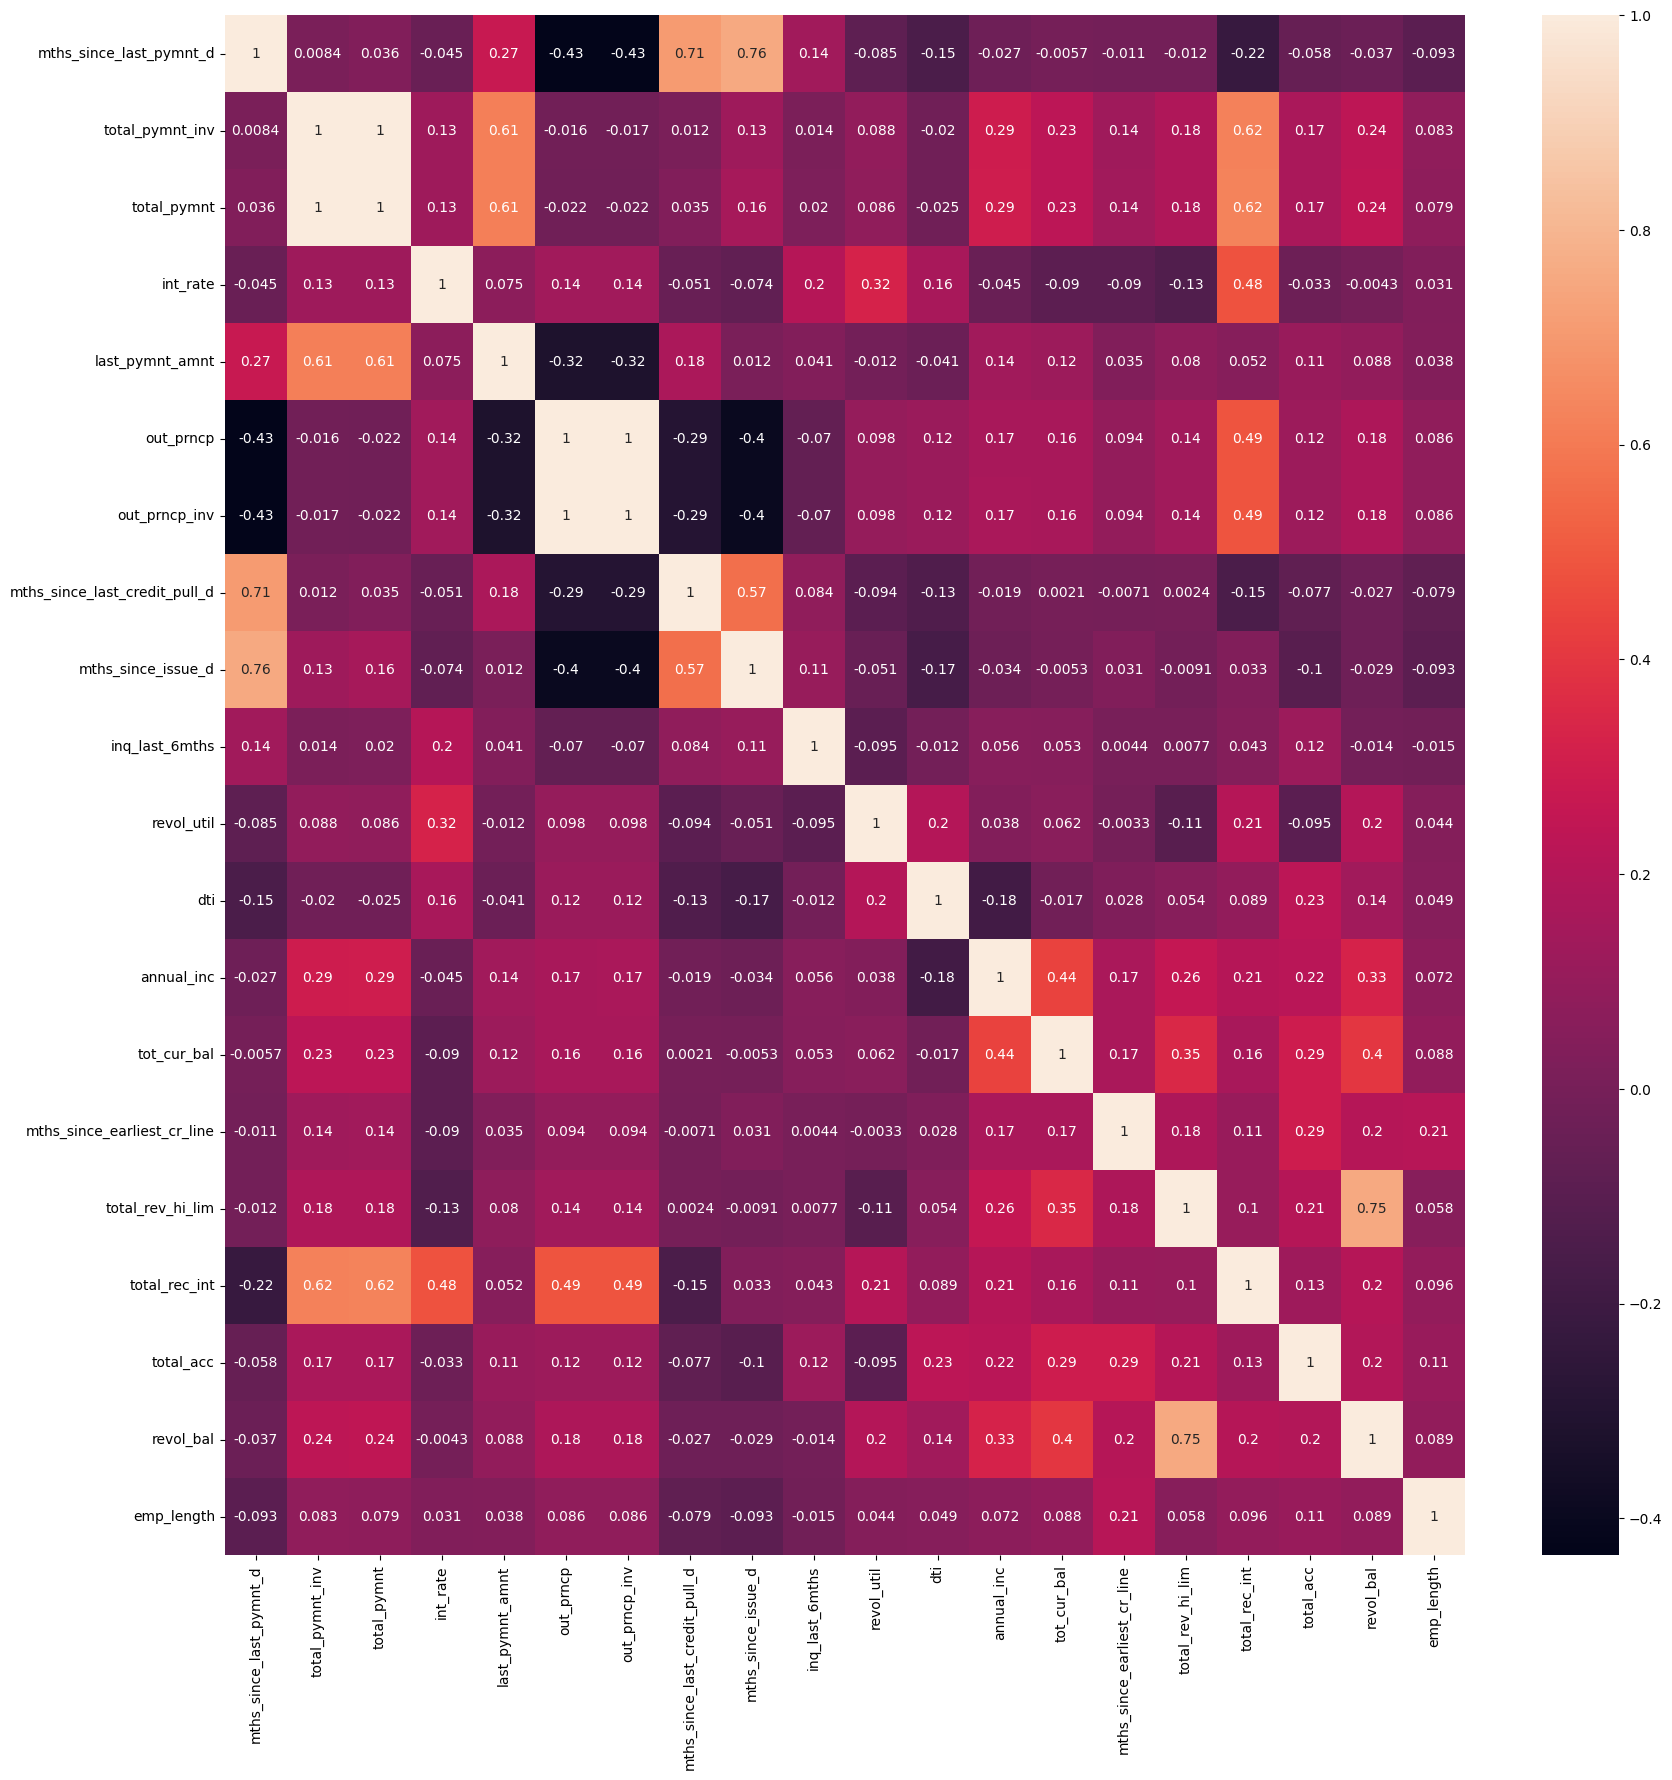

In [25]:
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True)
plt.savefig("heatmap.png")

In [26]:

drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(list(chi2_result.Feature[5:]))
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

In [27]:
def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)
col_to_drop(X_train, drop_columns_list)

In [28]:
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df


In [29]:
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status', 'purpose'])

In [30]:
def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

In [31]:
X_test["emp_length"] = X_test["emp_length"].str.replace("+","")
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status', 'purpose'])
# reindex the dummied test set variables to make sure all the feature columns in the training set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

In [32]:
X_test['mths_since_earliest_cr_line']

395346    341.0
376583    260.0
297790    236.0
47347     324.0
446772    351.0
          ...  
32147     326.0
78936     160.0
459582    175.0
454915    346.0
223621    313.0
Name: mths_since_earliest_cr_line, Length: 93257, dtype: float64

In [40]:
ref_categories=  ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	

## Discretizing
Discretizing or binning numerical features is not usually recommended for machine learning algorithms because it can result in data loss. However, in credit scoring, where the goal is to create a scorecard, discretization is necessary. It allows borrowers to be classified into different categories based on their characteristics, such as income, and assigned scores accordingly.

## WoE Binning of Continuous Variables
WoE binning of continuous variables has been an industry practice since the 1960s and is supported by literature. Discretizing continuous features has several rationales, including legal requirements for interpretability and the ability to separate low and high-risk observations. It also ensures monotonicity, where the credit risk indicator changes consistently as you move from one bin to another. Discretization helps meet the assumptions of logistic regression models and allows for separate handling of missing and outlier values without making assumptions about imputation or outlier treatment.

In [41]:
def woe_discrete(df,cat_variable_name,y_df):
    df = pd.concat([df[cat_variable_name],y_df],axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:,[0,1,3]]
    df.columns = [df.columns.values[0],'n_obs','prop_good']
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
    

In [42]:
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

In [43]:
sns.set()

In [44]:
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new
reg = LogisticRegression(max_iter=1000, class_weight = 'balanced')
woe_transform = WoE_Binning(X)
pipeline = Pipeline(steps=[('woe', woe_transform), ('model', reg)])

In [52]:
X_test_woe_transformed = woe_transform.fit_transform(X_test)

In [ ]:

# Calculate y_hat_test and y_hat_test_proba
y_hat_test = pipeline.predict(X_test)
y_hat_test_proba = pipeline.predict_proba(X_test)[:, 1]

# Create y_test_proba DataFrame
y_test_temp = y_test.copy().reset_index(drop=True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba)], axis=1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba']
y_test_proba.index = X_test.index

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(fpr, tpr)
plt.plot(fpr, fpr, linestyle='--', color='k')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')

In [49]:
# Calculate AUROC and Gini
AUROC = roc_auc_score(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
Gini = AUROC * 2 - 1
print('AUROC: %.4f' % AUROC)
print('Gini: %.4f' % Gini)


Mean AUROC: 0.8652
Gini: 0.7305


Text(0.5, 1.0, 'PR curve')

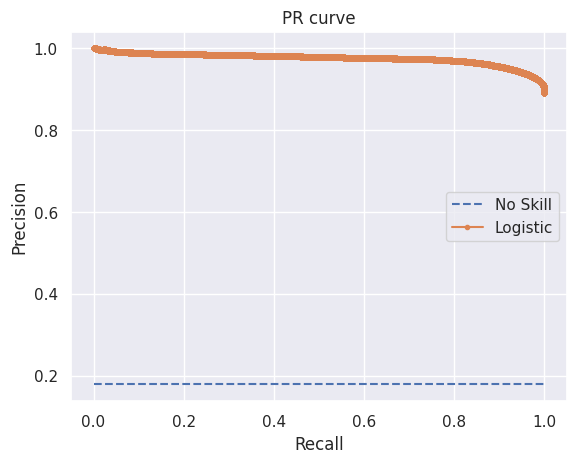

In [60]:

# Plot PR curve
no_skill = len(y_test[y_test == 1]) / len(y)  # calculate the no skill line
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
precision, recall, thresholds = precision_recall_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
plt.plot(recall, precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR curve')

In [61]:
# Create summary_table with feature names and coefficients
feature_name = X_train_woe_transformed.columns.values
summary_table = pd.DataFrame({'Feature name': feature_name})
summary_table['Coefficients'] = np.transpose(pipeline['model'].coef_)
summary_table.index = summary_table.index + 1
summary_table.loc[0] = ['Intercept', pipeline['model'].intercept_[0]]
summary_table.sort_index(inplace=True)

In [62]:
summary_table

,Feature name,Coefficients
0,Intercept,2.948682
1,grade:A,0.967278
2,grade:B,0.777480
3,grade:C,0.599622
4,grade:D,0.475237
5,grade:E,0.323460
6,grade:F,0.183203
7,home_ownership:OWN,-0.049609
8,home_ownership:OTHER_NONE_RENT,-0.110759
9,verification_status:Source Verified,-0.269925


In [66]:


# Create a new dataframe with reference categories
df_ref_categories = pd.DataFrame(ref_categories, columns=['Feature name'])
df_ref_categories['Coefficients'] = 0

# Concatenate summary_table and df_ref_categories
df_scorecard = pd.concat([summary_table, df_ref_categories]).reset_index()

# Create a new column for original feature names
df_scorecard['Original feature name'] = df_scorecard['Feature name'].str.split(':').str[0]

# Define min and max thresholds for scorecard
min_score = 300
max_score = 850

# Calculate sum of minimum and maximum coefficients for each original feature name
min_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].min().sum()
max_sum_coef = df_scorecard.groupby('Original feature name')['Coefficients'].max().sum()

# Calculate preliminary scores based on coefficients
df_scorecard['Score - Calculation'] = df_scorecard['Coefficients'] * (max_score - min_score) / (
    max_sum_coef - min_sum_coef)
df_scorecard.loc[0, 'Score - Calculation'] = (
    (df_scorecard.loc[0, 'Coefficients'] - min_sum_coef) /
    (max_sum_coef - min_sum_coef)
) * (max_score - min_score) + min_score

# Round preliminary scores
df_scorecard['Score - Preliminary'] = df_scorecard['Score - Calculation'].round()

# Adjust min and max scores to align with rounding differences
df_scorecard['Difference'] = df_scorecard['Score - Preliminary'] - df_scorecard['Score - Calculation']
df_scorecard['Score - Final'] = df_scorecard['Score - Preliminary']
df_scorecard.loc[0, 'Score - Final'] = 598

# Calculate credit scores for the test set
X_test_woe_transformed = woe_transform.fit_transform(X_test)
X_test_woe_transformed.insert(0, 'Intercept', 1)

scorecard_scores = df_scorecard['Score - Final']
X_test_woe_transformed = pd.concat([X_test_woe_transformed,
                                    pd.DataFrame(dict.fromkeys(ref_categories, [0] * len(X_test_woe_transformed)),
                                                 index=X_test_woe_transformed.index)], axis=1)

scorecard_scores = scorecard_scores.values.reshape(102, 1)
y_scores = X_test_woe_transformed.dot(scorecard_scores)

# Calculate score cutoff for loan approvals
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold: %f' % (best_thresh))

# Create a dataframe with thresholds and corresponding scores
df_cutoffs = pd.DataFrame(thresholds, columns=['thresholds'])
df_cutoffs['Score'] = ((np.log(df_cutoffs['thresholds'] / (1 - df_cutoffs['thresholds'])) - min_sum_coef) *
                       ((max_score - min_score) / (max_sum_coef - min_sum_coef)) + min_score).round()

# Define a function to count the number of approved applications
def n_approved(p):
    return np.where(y_test_proba['y_hat_test_proba'] >= p, 1, 0).sum()

# Calculate number of approved and rejected applications for each threshold
df_cutoffs['N Approved'] = df_cutoffs['thresholds'].apply(n_approved)
df_cutoffs['N Rejected'] = y_test_proba['y_hat_test_proba'].shape[0] - df_cutoffs['N Approved']

# Calculate approval and rejection rates
df_cutoffs['Approval Rate'] = df_cutoffs['N Approved'] / y_test_proba['y_hat_test_proba'].shape[0]
df_cutoffs['Rejection Rate'] = 1 - df_cutoffs['Approval Rate']


Best Threshold: 0.192950


In [75]:
# Filter for ideal threshold
df_cutoffs[df_cutoffs['thresholds'].between(best_thresh*0.99,best_thresh)]

,thresholds,Score,N Approved,N Rejected,Approval Rate,Rejection Rate
6902,0.191024,493.0,86293,6964,0.925325,0.074675
6903,0.191050,493.0,86292,6965,0.925314,0.074686
6904,0.191086,493.0,86291,6966,0.925303,0.074697
6905,0.191094,493.0,86290,6967,0.925292,0.074708
6906,0.191106,493.0,86289,6968,0.925282,0.074718
...,...,...,...,...,...,...
7027,0.192905,493.0,86168,7089,0.923984,0.076016
7028,0.192907,493.0,86167,7090,0.923974,0.076026
7029,0.192910,493.0,86166,7091,0.923963,0.076037
7030,0.192942,493.0,86165,7092,0.923952,0.076048


In [63]:
df_scorecard

,index,Feature name,Coefficients,Original feature name,Score - Calculation,Score - Preliminary,Difference,Score - Final
0,0,Intercept,2.948682,Intercept,604.318788,604.0,-0.318788,598.0
1,1,grade:A,0.967278,grade,24.564072,25.0,0.435928,25.0
2,2,grade:B,0.777480,grade,19.744139,20.0,0.255861,20.0
3,3,grade:C,0.599622,grade,15.227432,15.0,-0.227432,15.0
4,4,grade:D,0.475237,grade,12.068678,12.0,-0.068678,12.0
5,5,grade:E,0.323460,grade,8.214289,8.0,-0.214289,8.0
6,6,grade:F,0.183203,grade,4.652453,5.0,0.347547,5.0
7,7,home_ownership:OWN,-0.049609,home_ownership,-1.259818,-1.0,0.259818,-1.0
8,8,home_ownership:OTHER_NONE_RENT,-0.110759,home_ownership,-2.812723,-3.0,-0.187277,-3.0
9,9,verification_status:Source Verified,-0.269925,verification_status,-6.854764,-7.0,-0.145236,-7.0
